# Modelado, métricas y conclusiones
En este tercer notebook, nos centraremos en aplicar los modelos aprendidos a lo largo del curso, se harán dos modelos: 1. Machine Learning ; 2. Deep Learning.

Además, se unifica con el último notebook pero en una sección aparte, donde se evaluarán los modelos, se incluirán diferentes métricas y se compararán las prestaciones de ambas opciones. Por último, se ha añadido una visualización 2D de los Embeddings clasificando en 3 grupos: 'good', 'bad', 'regular'.

En caso de tener tiempo suficiente, me gustaría experimentar con BERT ya que me resulta llamativo el potencial que puede tener y comprobar la mejora en la precisión del análisis de sentimiento.

Para aplicar los modelos, lo primero que se hará es separar el dataset en train y test.

In [ ]:
!pip install -r requirements.txt
!pip install utils.py

import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
from stop_words import get_stop_words # Preprocesado
import unicodedata # Preprocesado
import re # Preprocesado
import gzip


from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.0 MB/s eta 0:00:00
  Created wheel for pyDAWG: filename=pyDAWG-1.0.1-cp310-cp310-linux_x86_64.whl size=62203 sha256=ffcbc9e3b2e3c0a5ddc13eabcecbb14f16e65566c0b2cb8cdc0fe5f0e20c87ea
  Stored in directory: /root/.cache/pip/wheels/15/5a/ec/7dfb31587fa2fee403d96efdb4ba07a1f85fb1aedf74c97da5
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=5364169126f59ede46fc28ce4adc632c0100d61d14ee2af491725cccde5fd7fc
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for 

In [ ]:
df = pd.read_csv("/content/cds_&_vinyl_prepoc_done.csv", index_col = None)

In [ ]:
df = df.dropna(subset=['processedReview'])

# Separamos en conjunto de train y test

Creamos los conjuntos de entrenamiento (80% del total) y test (20%). Se estratifica para dividir ambos datasets lo más parejos posibles.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['processedReview'],
    df['overall_binary'],
    train_size=0.80,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=df['overall_binary']
)

In [ ]:
X_train.iloc[:10]

3969    first saw band tv curious like big deal rememb...
1094    really good memorable songs distorted cliches ...
3122    except title track hated every minute tumblewe...
5952    curse hidden mirror blends old title stalk for...
402     soporific word wanted use long dreary dull sta...
49      even ardent boston fan consider buying album u...
731     john butt proscribed australian knappertsbusch...
2332    just one day see lot negative comments sound a...
4619    hate clean figured clean guessing think can li...
2408    take opportuniy share world something plaguing...
Name: processedReview, dtype: object

In [ ]:
y_train.iloc[:10]

3969    0
1094    0
3122    0
5952    1
402     0
49      0
731     0
2332    0
4619    1
2408    0
Name: overall_binary, dtype: int64

# MODELO 1: MACHINE LEARNING (Extracción de features)

Entre utilizar CountVectorizer o TF-IDF, se decide utilizar la segunda de ella debido a que:

El Count Vectorizer solo cuenta la frecuencia absoluta de los términos, mientras que el TF-IDF considera tanto la frecuencia como la importancia relativa en el corpus, disminuyendo el peso de términos comunes y aumentando el peso de términos raros.

Es por ello que, el CountVectorizer es más adecuado para tareas simples y análisis de documentos cortos pero, en este caso, que se cuenta con documentos más extensos y donde la importancia relativa de las palabras toma sentido para el análisis de sentimiento.

Los parámetros y valores que se definen son:

* ngram_range: (1, 2), de cara a codificar de manera más rica el contexto de cada palabra se trabajará con 1-grams y 2-grams.
* max_df: 0.95, al haber realizado una etapa de preprocesado en la que se eliminan stopwords no se requiere volver a eliminar tokens muy frecuentes.
* min_df: 3, tokens con una frecuencia baja se interpretan como outliers, posiblemente typos u otro tipo de errores.
* max_features: 2500, al trabajar con 1-gram y 2-grams seleccionamos un tamaño de vocabulario grande que nos permita contemplar los top n-grams más representativos.

In [ ]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 2)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, ngram_range=(1, 2),
                strip_accents='ascii')

In [ ]:
print(list(cv.vocabulary_.items())[:20])

[('first', 745), ('saw', 1913), ('band', 154), ('tv', 2321), ('curious', 453), ('like', 1197), ('big', 196), ('deal', 477), ('remember', 1820), ('things', 2237), ('go', 845), ('playing', 1639), ('alright', 68), ('thing', 2236), ('kinda', 1140), ('makes', 1312), ('ok', 1506), ('far', 702), ('feel', 719), ('vocals', 2380)]


In [ ]:
print(len(cv.vocabulary_))

2500


Se observa que con el tiempo necesario, se deberían repasar el prepocesamiento para tratar en las Stopwords añadir palabras que se repiten mucho y no están aportando información sobre el sentimiento de la review, como por ejemplo: sound, tour, years, ago, chicado, sounding...

## TF-IDF scores del training set y test set

In [ ]:
X_test.isna().any()

False

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Score IDF de algunas palabras

In [ ]:
words_example = [
    'work',
    'recordings',
    'interesting',
    'want',
    'years',
    'sounding',
    'excellent',
    'hillarious',
    'worst',
    'first',
    'love'
]

In [ ]:
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
work                3.641
recordings          4.523
interesting         4.268
want                3.310
years               3.399
sounding            4.642
excellent           4.339
hillarious          OOV                 
worst               4.135
first               2.639
love                2.866


## Palabras con el TF-IDF en alguna review

In [ ]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 3635
Sentiment: 1
Review: took chance cd liked missed previous one enough enticing tracks get purchase album glad


In [ ]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 3635:
             tfidf
missed    0.396262
purchase  0.353093
chance    0.353093
glad      0.343005
took      0.306655
liked     0.296567
previous  0.291039
enough    0.257349
tracks    0.217547
get       0.175574

Top 10 words with lowest TF_IDF in the review 3635:
             tfidf
glad      0.343005
took      0.306655
liked     0.296567
previous  0.291039
enough    0.257349
tracks    0.217547
get       0.175574
cd        0.167973
one       0.136809
album     0.134046


## $\chi²$ scores

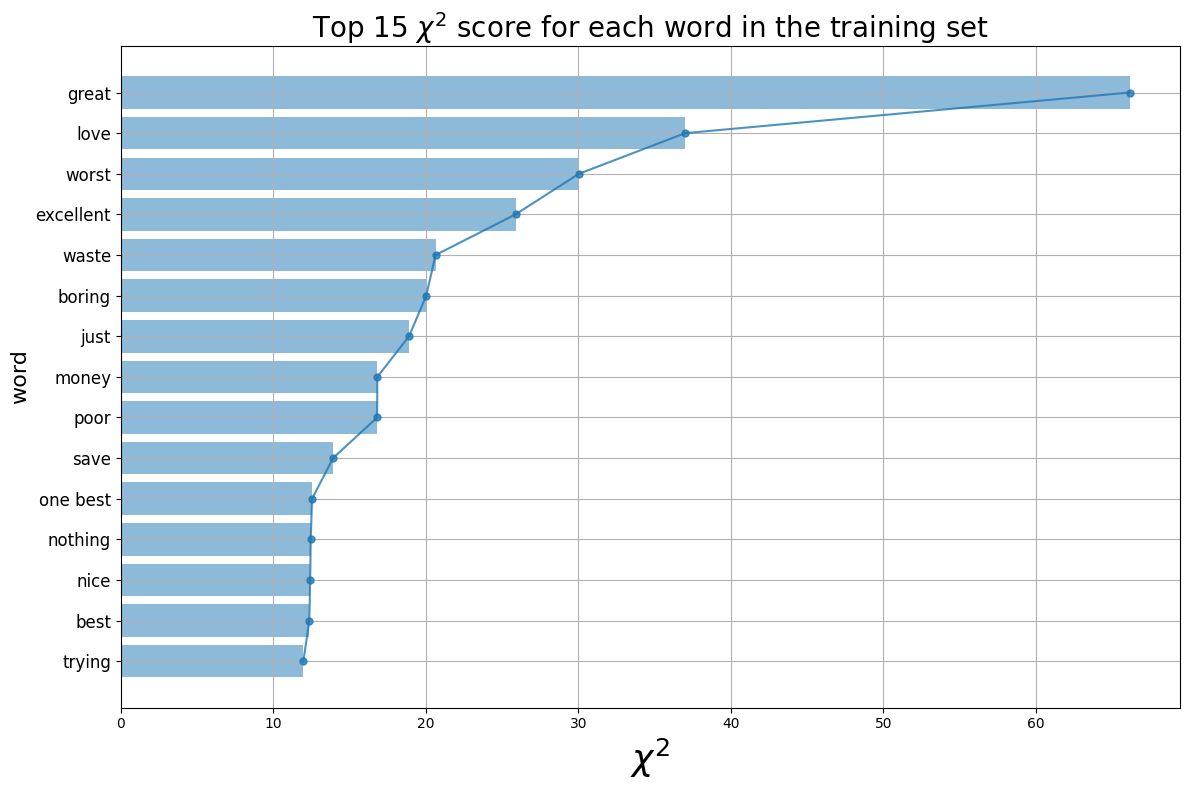

In [ ]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Entrenamiento


Para este apartado empelaremos un modelo que es  adecuado para tareas de clasificación binaria con variables discretas. La aproximación será simple en el sentido de que no se destinarán esfuerzos al tuning de hiperparametros.

In [ ]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.7422810333963453
Accuracy for C=0.05: 0.7655954631379962
Accuracy for C=0.25: 0.782608695652174
Accuracy for C=0.5: 0.7876496534341525
Accuracy for C=1: 0.7939508506616257
Accuracy for C=10: 0.7763074984247007
Accuracy for C=100: 0.741650913673598


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for C=1000: 0.7114051669817265
Accuracy for C=10000: 0.704473850031506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# MODELO 2: DEEP LEARNING


Se utilizará en este subapartado una red neuronal recurrente (RNN) como modelo de Deep Learning.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer

vocabulary_size = 40000

In [ ]:
max = 0
mean = []
for rev in X_train:
  length = len(rev)
  mean.append(len(rev))
  if length > max:
    max = length

sum(mean) / len(mean)

368.4371832954744

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)

In [ ]:
tokenizer.fit_on_texts(X_test)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.utils import pad_sequences

max_words = 600

X_train_dl = pad_sequences(X_train_sequences, maxlen=max_words)
X_test_dl = pad_sequences(X_test_sequences, maxlen=max_words)

In [ ]:
embedding_size = 32
model_rnn = Sequential()
model_rnn.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dense(1, activation='sigmoid'))

print(model_rnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 600, 32)           1280000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               20608     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1300737 (4.96 MB)
Trainable params: 1300737 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32
num_epochs = 8

X_valid, y_valid = X_train_dl[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train_dl[batch_size:], y_train[batch_size:]  # rest for training

model_rnn.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/8
178/178 [==============================] - 171s 954ms/step - loss: 0.6916 - accuracy: 0.5447 - val_loss: 0.6727 - val_accuracy: 0.6250
Epoch 2/8
178/178 [==============================] - 119s 666ms/step - loss: 0.6784 - accuracy: 0.5774 - val_loss: 0.6911 - val_accuracy: 0.5938
Epoch 3/8
178/178 [==============================] - 110s 617ms/step - loss: 0.6144 - accuracy: 0.6821 - val_loss: 0.7559 - val_accuracy: 0.5312
Epoch 4/8
178/178 [==============================] - 105s 591ms/step - loss: 0.4731 - accuracy: 0.7846 - val_loss: 0.7645 - val_accuracy: 0.5938
Epoch 5/8
178/178 [==============================] - 102s 572ms/step - loss: 0.3260 - accuracy: 0.8651 - val_loss: 0.7190 - val_accuracy: 0.6562
Epoch 6/8
178/178 [==============================] - 102s 573ms/step - loss: 0.2111 - accuracy: 0.9183 - val_loss: 0.8083 - val_accuracy: 0.6875
Epoch 7/8
178/178 [==============================] - 99s 557ms/step - loss: 0.1423 - accuracy: 0.9515 - val_loss: 0.8868 - val_acc

In [ ]:
import os

cache_dir = os.path.join("cache", "sentiment_analysis")

model_file = "rnn_model.h5"  # HDF5 file
model_rnn.save(os.path.join(cache_dir, model_file))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Métricas y conclusiones

En este último documento, el cuarto de la serie, se incluirán algunas métricas para valorar cómo lo han hecho los modelos que se han entrenado y se harán unas conclusiones entre ellos para determinar cual han tenido mayor prestaciones.

## Evaluación de modelo de Machine Learning

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[563 234]
 [235 555]]

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       797
           1       0.70      0.70      0.70       790

    accuracy                           0.70      1587
   macro avg       0.70      0.70      0.70      1587
weighted avg       0.70      0.70      0.70      1587

Accuracy score:0.704473850031506


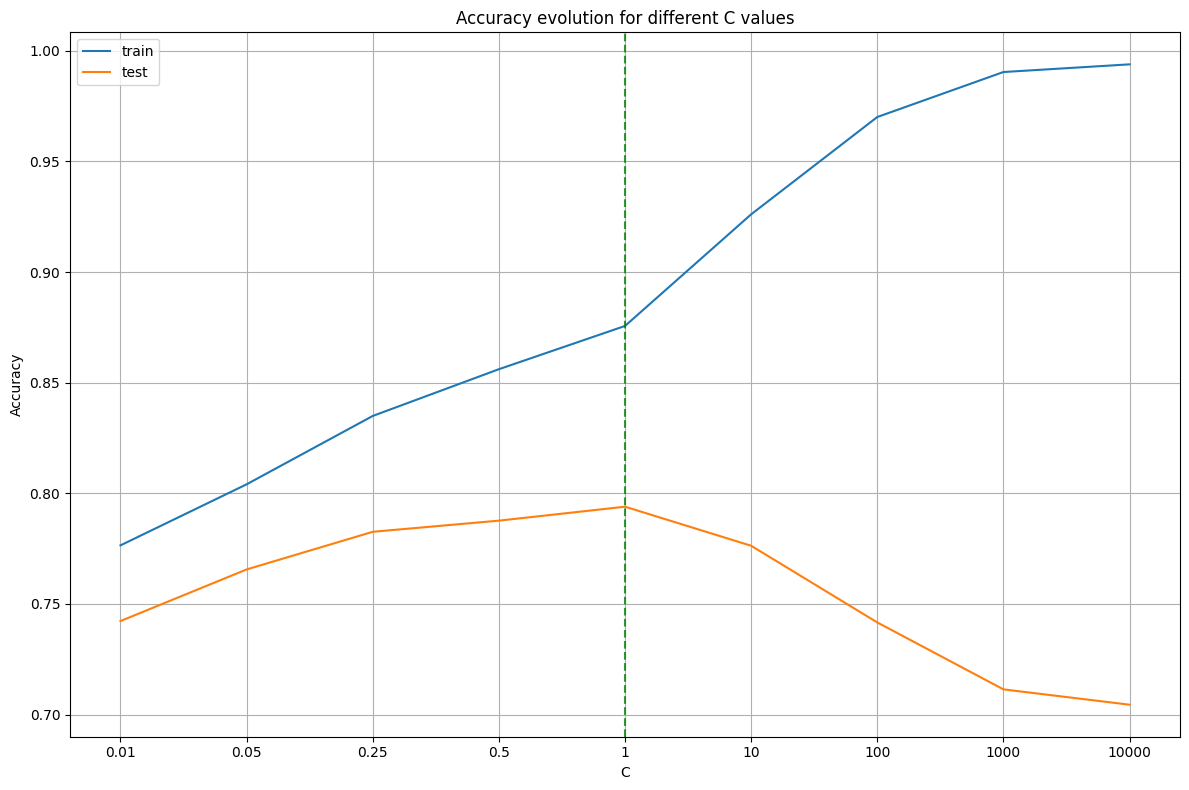

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Se observa que las 'mejores' prestaciones del modelo ocurren con c = 1. A partir de entonces, se presenta overfitting en el mismo.

# Predict
Por último, se va a implementar una función en la que se pueda hacer una predicción con el modelo que ha sido entrenado. Se realizará con 3 reviews del dataset de test y se comparará la predicción con el valor real.

In [ ]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['overall_binary']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [ ]:
for i in random.sample(range(0, len(df)), 3):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 219
Actual sentiment: 0
Prediction: [0]

Review no. 385
Actual sentiment: 0
Prediction: [0]

Review no. 4874
Actual sentiment: 1
Prediction: [0]


## Visualizar en 2D en función de palabras similares (Embeddings Visualization)

Se quiere visualizar en una gráfica las palabras que se encuentran más 'cerca' de una definición como bueno 'good' o malo 'bad' y ver si tiene algún sentido la representación que se consigue.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import multiprocessing

In [ ]:
cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador

w2v_sg = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [ ]:
sent = [row.split() for row in df['processedReview']]
w2v_sg.build_vocab(sent, progress_per=10000)

In [ ]:
w2v_sg.train(sent, total_examples=w2v_sg.corpus_count, epochs=30, report_delay=1)

(4495796, 12817320)

In [ ]:
keys = ['good','bad','regular']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

Ahora toca reducir la dimensionalidad para poder representarlo en un plano.

In [ ]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

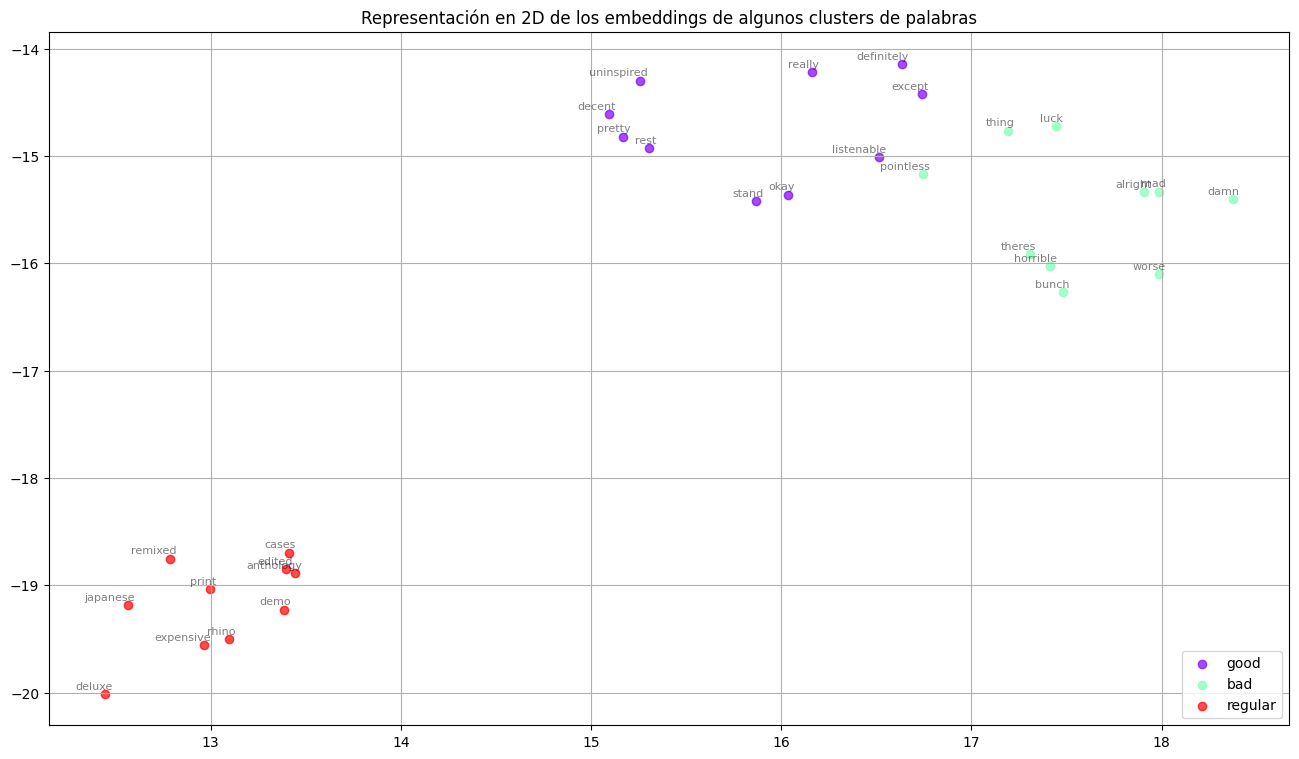

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

Es llamativo que las palabras 'good' y 'bad' estén tan cerca representadas y, que por el contrario, 'regular' esté tan lejos. Sin embargo, las palabras que aparecen clasificadas para las dos primeras categorías ('good' y 'bad') algunas palabras tienen sentido.

## Evaluación de modelo de deep learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd

In [ ]:
scores = model_rnn.evaluate(X_test_dl, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.535290002822876


Los resultados obtenidos con la RNN son muy inferiores con respecto al modelo de machine learning. Primera iteración Test accuracy: 0.44 (test).

Se hace una segunda prueba:
. Aumentando la cantidad de Epochs de 3 a 5.

. Disminuyendo el batch size de 128 a 64.

. En el modelo se disminuye el embedding_size de 32 a 16 y las neuronas de la capa SimpleRNN de 256 a 128.

.Se aumenta el tamaño del vocabulario de 5000 a 80000.

*Con estos cambios, el test de accuracy pasa de 0.44 a 0.55. (Hay muestras de overfitting ya que la accuracy de train es mucho más alta que las otras dos).*

Se hace una tercera iteración:

. Nº Epochs: 8

. batch size: 32

. Tamaño vocabulario: 40.000

. max_words: 600

*En esta ocasión los resultados en el test_accuracy son 0.53, por lo que con estas pruebas se puede decir que de las tres opciones que se han iterado, el que mejores resultados ha presentado es la segunda, pero no se ha conseguido mejorar los resultados obtenidos con el modelo de machine learning.*